# ML Walkthrough

We spend a lot of money on education every year! In general, we believe that the more we spend, the better our schools are and the better our students perform. But do we really know that?

To adress these questions, we will spend today looking at a US education dataset and see what we can learn about indicators of student performance. In particular, we want to answer the question: what are useful indicators to predict student performance on national exams?

## Data Poking

We start off by importing our data and seeing what we've got:

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Suppress Pandas SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [7]:
df = pd.read_csv('../data/states_edu.csv')

In [8]:
df.shape

(1715, 25)

We are given that this dataset describes "K-12 financial, enrollment, and achievement data in one place". Each row is one state in one year, and includes variables for revenue categories, expenditure types, enrollment numbers, and exam scores.

In [9]:
df.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,NaN,NaN,731634.0,208.0,252.0,207.0,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,NaN,NaN,122487.0,NaN,NaN,NaN,NaN
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,NaN,NaN,673477.0,215.0,265.0,209.0,NaN
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,NaN,NaN,441490.0,210.0,256.0,211.0,NaN
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,NaN,NaN,5254844.0,208.0,261.0,202.0,NaN


In [10]:
df.columns

Index(['PRIMARY_KEY', 'STATE', 'YEAR', 'ENROLL', 'TOTAL_REVENUE',
       'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE',
       'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G', 'GRADES_ALL_G', 'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE',
       'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE'],
      dtype='object')

## Data Cleanup

In [11]:
# let's rename our columns to make them more intuitive
df.rename({
    'GRADES_PK_G':'ENROLL_PREK',
    'GRADES_KG_G':'ENROLL_KINDER',
    'GRADES_4_G':'ENROLL_4',
    'GRADES_8_G':'ENROLL_8',
    'GRADES_12_G':'ENROLL_12',
    'GRADES_1_8_G':'ENROLL_PRIMARY',
    'GRADES_9_12_G':'ENROLL_HS',
    'GRADES_ALL_G':'ENROLL_ALL',
    'ENROLL':'ENROLL_ALL_EST'
    },
    axis=1,inplace=True)
#inplace return copy of dataframe

In [ ]:
df.head()

Looking closer at the data, there are a lot of 'NaN' values... what are those?

In [ ]:
# this is a numpy value which represents missnig or invalid data (not-a-number)
np.NaN

In [ ]:
# it is treated as a float, so it is easily compatible with numpy and pandas
type(np.NaN)

We can easily find and describe missing values with `pandas`.

In [ ]:
# this will print the number of missing values in each column
df.isna().sum()

In [ ]:
# this will print the number of valid values in each column
df.notna().sum()

In [ ]:
# notice that pandas will often ignore missing values by default
df.count()

One way we can deal with missing values is by dropping rows with any null value.

In [ ]:
# by default, dropna will remove all rows with at least 1 nan
df.dropna()

Dropping rows with any nan leaves us only 355 rows -- do we actually need all our data to be complete? Which rows are actually important?

That depends on what you want to do with the data! 

For the purpose of this tutorial, let's say we are particularly interested in 8th grade reading scores.

In [12]:
# In that case, we will drop all the rows where the 8th grading reading score is missing
df.dropna(subset=['AVG_READING_8_SCORE'], inplace=True)

Another way of dealing with missing values is filling them in with a value that is representative of other values in the column. Medians and means are common choices and are suited to different scenarios.

In our data, we have two columns representing total student enrollment: `ENROLL_ALL_EST` and `ENROLL_ALL`. We also have enrollment data divided by school group. Let's see if we can use them to fill each other in.

In [13]:
df["ENROLL_ALL"].isna().sum()

75

In [ ]:
# first let's check if the individual enrollments actually sum up to total enrollment
(df["ENROLL_ALL"]-df["ENROLL_PREK"]-df["ENROLL_KINDER"]-df["ENROLL_PRIMARY"]-df["ENROLL_HS"]).describe()

In [ ]:
# enrollment differences as a percent
((df["ENROLL_ALL"]-df["ENROLL_PREK"]-df["ENROLL_KINDER"]-df["ENROLL_PRIMARY"]-df["ENROLL_HS"])/df["ENROLL_ALL"]*100).describe()

Looks like the individual enrollments do sum up to the total enrollment in most cases! And even when they don't, the deviation is usually not drastic.

This is not a terrible way to estimate total enrollment.

In [ ]:
df['ENROLL_ALL'] = df['ENROLL_ALL'].fillna(df["ENROLL_PREK"]+df["ENROLL_PRIMARY"]+df["ENROLL_HS"])

In [ ]:
# this didn't actually do anything!
df["ENROLL_ALL"].isna().sum()

In [ ]:
# turns out, data missing ENROLL_ALL is also missing all other enrollment data
df[df["ENROLL_ALL"].isna()][['ENROLL_PREK','ENROLL_PRIMARY','ENROLL_HS','ENROLL_ALL_EST']].notna().any()

In [ ]:
# but there are rows with enrollment estimates
df[df.ENROLL_ALL_EST.isna()]["ENROLL_ALL"].notna().sum()

In [ ]:
# let's see if we can fill these in
((df["ENROLL_ALL"] - df["ENROLL_ALL_EST"])/df["ENROLL_ALL"]).describe()

In [ ]:
# since the average error between estimated and actual enrollment is ~2%, I'm going to go ahead and fill in the missing estimates
df["ENROLL_ALL_EST"] = df["ENROLL_ALL_EST"].fillna(df["ENROLL_ALL"])

What we just did was data cleanup! Most data scientists will tell you that data cleanup and preprocessing will take >60% of the total time for a given project... We just gave you a small teaser here but you'll be seeing a lot more of it :)

## Feature Engineering

Something else you'll see a lot of is feature engineering. In this step, we manipulate the data set so the data is can be used for analysis more readily.

Here are some common methods of modifying features:

* Standardization
>helps some models account for different magnitude features, e.g. revenue is ~10x bigger than enrollment on average, but that doesn't make it more important
* Binning
>reduces the importance of small differences in data, e.g. exact enrollment probably doesn't matter, but there may still be a difference between 'small', 'medium', and 'large' schools
* Combining features
>combinations of features may matter more than the features on their own, e.g. educational expenditure as a percent of total expenditure is more informative about a state's priorities (states aren't all the same size)


In this case, we know our data is on the state level and also longitudinal (over time). 

This format introduces some complications. For example, the state of California will obviously spend more than New Jersey becuase they have more people... how can we account for this?

In [ ]:
# let's create a new column which represents expenditure per student
df['SUPPORT_SERVICES_EXPENDITURE_PER_STUDENT'] = df['SUPPORT_SERVICES_EXPENDITURE'] / df['ENROLL_ALL']

## EDA

Now let's do some EDA (exploratory data analysis)!

You should always perform EDA when you are beginning to work with a new dataset. EDA will reveal irregularities and interesting patterns in the data, both of which are hugely informative for your work later.

The first step in EDA is usually looking at the variable of interest in isolation. What's its distribution? How has it changed over time?

<Axes: title={'center': 'Distribution of 8th Grade Reading Scores'}, ylabel='Frequency'>

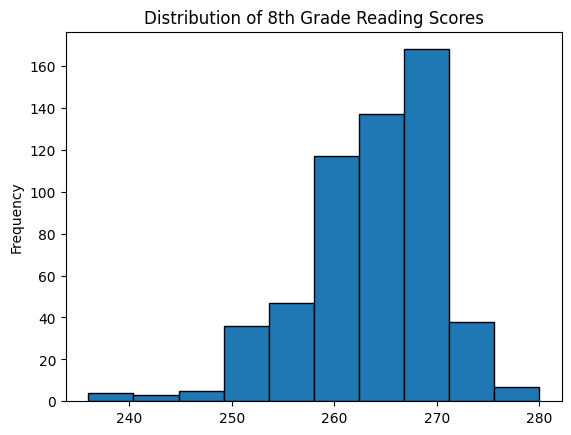

In [14]:
# note - this test is scored out of 500 according to the NAEP website
df.AVG_READING_8_SCORE.plot.hist(title="Distribution of 8th Grade Reading Scores", edgecolor="black")

Text(0.5, 1.0, '8th Grade Reading Score Over Time')

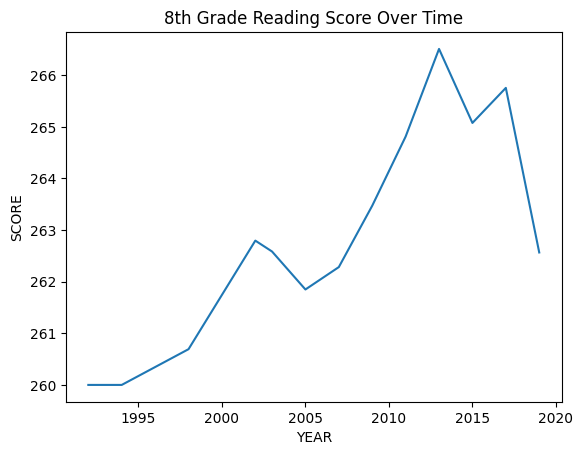

In [15]:
df.groupby('YEAR')["AVG_READING_8_SCORE"].mean().plot()
plt.ylabel('SCORE')
plt.title('8th Grade Reading Score Over Time')

Then, we can investigate the relationship between the variable of interest and other (potentially) relevant variables.

In [ ]:
df.plot.scatter(x='ENROLL_8', y='AVG_READING_8_SCORE', alpha=0.6)
plt.xlabel('8th Grade Enrollment')
plt.ylabel('8th Grade Reading Score')

In [ ]:
df.plot.scatter(x='STATE_REVENUE', y='AVG_READING_8_SCORE', alpha=0.6)
plt.xlabel('State Revenue')
plt.ylabel('8th Grade Reading Score')

In [ ]:
df.plot.scatter(x='INSTRUCTION_EXPENDITURE', y='AVG_READING_8_SCORE', alpha=0.6)
plt.xlabel('Instruction Expenditure')
plt.ylabel('8th Grade Reading Score')

In [ ]:
df.plot.scatter(x='AVG_READING_4_SCORE', y='AVG_READING_8_SCORE', alpha=0.8)

In [ ]:
df.plot.scatter(x='AVG_MATH_8_SCORE', y='AVG_READING_8_SCORE', alpha=0.8)

It seems 4th grade reading score and 8th grade math score are strongly correlated with 8th grade reading score. All the other variables that we investigated have weak or no correlation with 8th grade reading score.

So now that we know a bit about the data, what do we want to do with it? How am I going to frame this as a _machine learning_ project?

## Quick Intro to Machine Learning!

Unfortunately, we can't teach machine learning in single tutorial. For this tutorial, we're going to practice a simple _supervised learning_ problem. 

**Machine learning workflow:**
<img src=https://miro.medium.com/proxy/1*KzmIUYPmxgEHhXX7SlbP4w.jpeg width=500></img>

**Supervised learning:**
<img src=https://miro.medium.com/max/1050/1*-fniNC8gWI34qLAiBzgGZA.png width=800></img>

We have established that we are interested in 8th grade reading scores, so I want to make that my response variable (i.e. what I'm trying to predict).

Based on the EDA, I think that `ENROLL_8`, `AVG_MATH_8_SCORE`, and `AVG_READING_4_SCORE` would be interesting predictors to look at, so I will pick these as my input features.

**Regression**

In [ ]:
# test_train_split randomly splits the data into two parts -- 
# one for training the model (it uses this data to learn patterns)
# and one for testing the model (to make sure it performs well on data it hasn't seen before)
from sklearn.model_selection import train_test_split

In [ ]:
# X is commonly used to denote the input data
# y is used for the response / output data
X = df[['ENROLL_8','AVG_MATH_8_SCORE','AVG_READING_4_SCORE']].dropna()
y = df.loc[X.index]['AVG_READING_8_SCORE']

In [ ]:
# We also need to make sure there is no NaN in y
# This time, we will fill the NaN with the median of y 
# We prefer median to mean because EDA reveals that the response variable is left-skewed. Therefore, the mean may not represent the data very well
y.fillna(y.median(), inplace=True)

In [ ]:
# the test_size parameter defines what % of data is set aside for testing, 70 / 30 and 80 / 20 split are both typical
# we don't have a huge data set but we still want to have a decently sized testing set
# so we are using a 70 / 30 train / test split. 
# setting random_state explicitly ensures that I get the same results each time I run the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

Now to create and train a model! For simplicity, I'm going to use `sklearn`'s `LinearRegression` class.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()

In [ ]:
# fit is essentially the word sklearn uses for training
model.fit(X_train, y_train)

What we are doing here is called _least squares linear regression_. 

Let's say there are $k$ input variables, named $x_1$ through $x_k$ (here, I have $k=3$, $x_1$ = `ENROLL_8`, $x_2$ = `AVG_MATH_8_SCORE`, etc.)

The model is trying to find the one equation of the form that minimizes some error measure. In this case, that measure is residual sum of squares ([RSS](https://en.wikipedia.org/wiki/Residual_sum_of_squares)):

$y_{predicted} = intercept + \beta_0x_1 + \beta_1x_2 + ... + \beta_kx_k$ where $\beta_i$ are the coefficients. 

Notice there are exactly $k$ coefficients. We can interpret each coefficient by holding all other variables constant (_ceteris paribus_, if you are feeling fancy). 

For example, if $\beta_2=0.2$, we say "with all other variables held constant, a 1 point increase in average grade 8 math score results in a 0.2-point increase in reading score". 

In [ ]:
# You can see the intercepts and coefficients the model generates
print(model.intercept_)
print(model.coef_)

In [ ]:
# R^2 value describes how well a linear model fits the data
# It ranges between 0 and 1
# There are many caveats to R^2 but it is a good starting point
model.score(X_test, y_test)

In [ ]:
# mean error
np.mean(model.predict(X_test)-y_test)

In [ ]:
# mean absolute error
np.mean(np.abs(model.predict(X_test)-y_test))

In [ ]:
# root mean squared error -- penalizes large errors
np.mean((model.predict(X_test)-y_test)**2)**0.5

Now we can take a look at the model's predictions and how it differs from the actual data.

In [ ]:
col_name = 'AVG_MATH_8_SCORE'

f = plt.figure(figsize=(12,6))
plt.scatter(X_train[col_name], y_train, color = "red")
plt.scatter(X_train[col_name], model.predict(X_train), color = "green")

plt.legend(['True Training','Predicted Training'])
plt.xlabel(col_name)
plt.ylabel('Reading 8 score')
plt.title("Model Behavior On Training Set")

In [ ]:
col_name = 'AVG_MATH_8_SCORE'

f = plt.figure(figsize=(12,6))
plt.scatter(X_test[col_name], y_test, color = "blue")
plt.scatter(X_test[col_name], model.predict(X_test), color = "black")

plt.legend(['True testing','Predicted testing'])
plt.xlabel(col_name)
plt.ylabel('Reading 8 score')
plt.title("Model Behavior on Testing Set")

It would seem that our model works fairly well on the training set and also generalizes nicely to the testing set. This is a good thing! Sometimes models will work *too* well on the training set that it does poorly on the testing set. 

This is known as overfitting. We will have a lot more to say about it in the future.